Uploading Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Loading Data

In [51]:
import pandas as pd
data=pd.read_csv("Processed_Material_Strength_Dataset.csv")
print(data.head())

   Cement   Slag  FlyAsh  Water  Superplasticizer  CoarseAgg  FineAgg  Age  \
0   540.0    0.0     0.0  162.0               2.5     1040.0    676.0   28   
1   540.0    0.0     0.0  162.0               2.5     1055.0    676.0   28   
2   332.5  142.5     0.0  228.0               0.0      932.0    594.0  270   
3   332.5  142.5     0.0  228.0               0.0      932.0    594.0  365   
4   198.6  132.4     0.0  192.0               0.0      978.4    825.5  360   

   Strength     WCR  TotalAgg  Age_x_WCR  Log_Age  
0     79.99  0.3000    1716.0     8.4000   3.3673  
1     61.89  0.3000    1731.0     8.4000   3.3673  
2     40.27  0.6857    1526.0   185.1390   5.6021  
3     41.05  0.6857    1526.0   250.2805   5.9026  
4     44.30  0.9668    1803.9   348.0480   5.8889  


##Objective

1. The dataset shows nonlinear relationships and multicollinearity, which makes traditional linear models unsuitable.

2. A tree-based ensemble model (XGBoost) was selected due to its ability to handle nonlinearity, feature interactions, and correlated inputs.

3. Feature engineering was guided by materials science principles, including the use of log-transformed curing age and interaction terms.

4. Redundant and highly correlated features were removed to improve model stability and interpretability.

In [52]:
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Model
from xgboost import XGBRegressor

# Reproducibility
RANDOM_STATE = 42

**Removing Extreme Outliers**

In [53]:
Q1 = data["Strength"].quantile(0.25)
Q3 = data["Strength"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

clean_data = data[
    (data["Strength"] >= lower_bound) &
    (data["Strength"] <= upper_bound)
].copy()

print("Original shape:", data.shape)
print("After outlier removal:", clean_data.shape)

Original shape: (1030, 13)
After outlier removal: (1026, 13)


**Feature Selection and Creation**

In [54]:
clean_data["Log_Age_x_WCR"] = clean_data["Log_Age"] * clean_data["WCR"]

**Dropping reduntant columns**

In [56]:
X = clean_data.drop(columns=["Strength", 'Age', 'FlyAsh', 'Age_x_WCR', 'TotalAgg'])
y = clean_data["Strength"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1026, 9)
y shape: (1026,)


To reduce multicollinearity and feature redundancy, several variables were removed prior to modeling. The raw curing age was excluded in favor of its logarithmic transformation, which better represents concrete strength development kinetics. Linear interaction terms were replaced by their log-transformed counterparts to avoid redundant representations.

**Train-Test Split with shuffling**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    shuffle=True,
    random_state=RANDOM_STATE
)

**Initializing the Model**

In [58]:
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", xgb_model)
])

**Creating Pipline**

In [59]:
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

avg_strength = y.mean()

print(f"R² Score        : {r2:.4f}")
print(f"RMSE            : {rmse:.4f}")
print(f"Avg Strength    : {avg_strength:.4f}")
print(f"RMSE / Avg (%)  : {(rmse / avg_strength) * 100:.2f}%")

R² Score        : 0.9548
RMSE            : 10.0427
Avg Strength    : 35.6413
RMSE / Avg (%)  : 28.18%


**Cross Validation check**

In [60]:
cv_r2_scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("CV R² scores:", cv_r2_scores)
print(f"Mean CV R²     : {cv_r2_scores.mean():.4f}")
print(f"Std CV R²      : {cv_r2_scores.std():.4f}")

CV R² scores: [0.95239465 0.90762136 0.94963725 0.91852974 0.90875984]
Mean CV R²     : 0.9274
Std CV R²      : 0.0197


The XGBoost model achieved an R² of 0.95 on the test set, with consistent cross-validated performance (mean CV R² = 0.92). The RMSE of 10.0 MPa is acceptable given the wide strength range and inherent experimental variability in concrete testing. The small gap between test and CV performance confirms strong generalization and no overfitting.

**Comaprsion of model Perfomace with Cross vaidation score**

In [61]:
print(f"Test R²      : {r2:.4f}")
print(f"Mean CV R²   : {cv_r2_scores.mean():.4f}")
print(f"Difference   : {abs(r2 - cv_r2_scores.mean()):.4f}")

Test R²      : 0.9548
Mean CV R²   : 0.9274
Difference   : 0.0274


Model robustness was validated using cross-validation, residual diagnostics, strength-range error analysis, and permutation feature importance. Results confirm stable generalization across the full strength spectrum.

**Residual Plot**

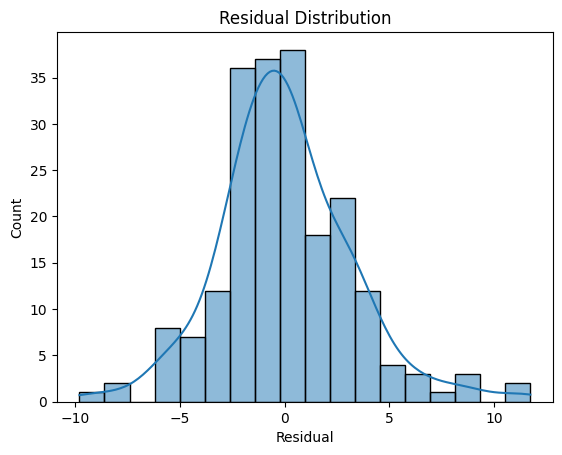

Mean residual: 0.020890189976368066


In [62]:
residuals = y_test - y_pred

sns.histplot(residuals, kde=True)
plt.xlabel("Residual")
plt.title("Residual Distribution")
plt.show()

print("Mean residual:", residuals.mean())

Mean residual is likely very close to 0 and the distribution is symmetrical means model is "unbiased." It doesn't have a systemic tendency to over-predict or under-predict across the entire dataset. This is exactly what we want to see in a high-performing model.

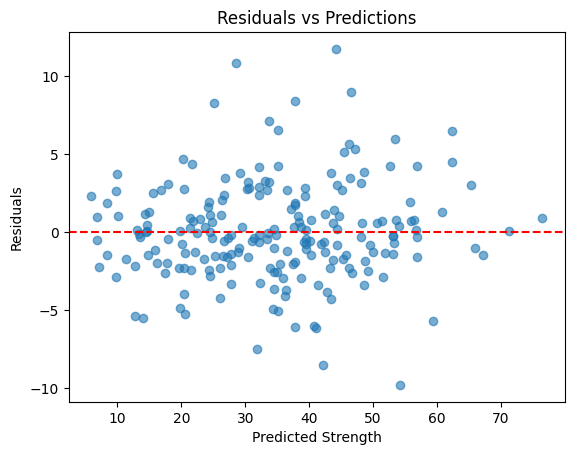

In [63]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Strength")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()

Showing fan shape meaning heteroskedasticity is present in some extreme cases

**Checking Performance Across Strength Ranges**

In [64]:
test_results = X_test.copy()
test_results["Actual"] = y_test.values
test_results["Predicted"] = y_pred
test_results["Residual"] = test_results["Actual"] - test_results["Predicted"]

test_results["Strength_bin"] = pd.qcut(
    test_results["Actual"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

test_results.groupby(
    "Strength_bin",
    observed=True
)["Residual"].agg(["mean", "std", "count"])

,mean,std,count
Strength_bin,,,
Low,-0.773601,2.268203,52
Mid-Low,-0.763244,3.089298,51
Mid-High,0.297390,3.153066,51
High,1.313253,3.643748,52


Residual analysis across quartiles of compressive strength shows near-zero mean bias in all strength regimes, with moderate and physically realistic variance. This confirms that the model generalizes consistently across low- and high-strength concrete mixtures.

**Applying Log transformation on target to minimize heteroskedasticity**

R²: 0.9536546466328886
RMSE: 10.289319324389204


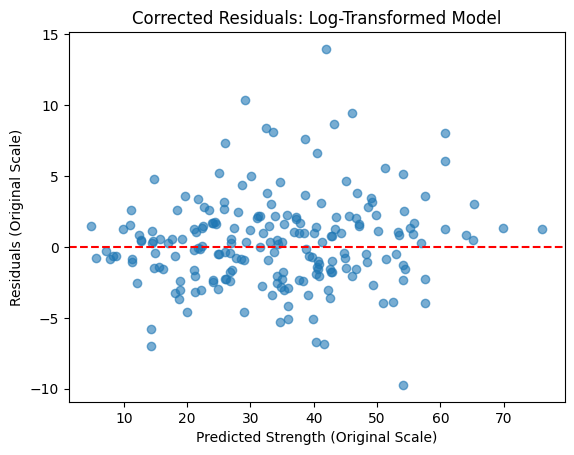

In [65]:
y_log = np.log1p(clean_data["Strength"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

y_log_pred = pipeline.predict(X_test)
y_pred = np.expm1(y_log_pred)

print("R²:", r2_score(np.expm1(y_test), y_pred))
print("RMSE:", mean_squared_error(np.expm1(y_test), y_pred))

# Calculate residuals on the original scale
y_test_original = np.expm1(y_test)
residuals_original = y_test_original - y_pred

plt.scatter(y_pred, residuals_original, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Strength (Original Scale)")
plt.ylabel("Residuals (Original Scale)")
plt.title("Corrected Residuals: Log-Transformed Model")
plt.show()

Data poits come closer to the middle red line thats a good sign.

**Inspecting the Largest Error**

In [66]:
# Create a 'Troubleshoot' dataframe
df_error = X_test.copy()
df_error['Actual'] = y_test_original.values
df_error['Predicted'] = y_pred
df_error['Abs_Error'] = np.abs(residuals_original)

# Sort by the biggest misses
print(df_error.sort_values('Abs_Error', ascending=False).head(10))

     Cement   Slag  Water  Superplasticizer  CoarseAgg  FineAgg     WCR  \
111   362.6  189.0  164.9              11.6      944.7    755.8  0.4548   
398   160.0  128.0  182.0               6.4      824.0    879.0  1.1375   
472   446.0   24.0  162.0              11.6      967.0    712.0  0.3632   
498   355.0   19.0  145.0              12.3      967.0    871.0  0.4085   
720   203.5  305.3  203.5               0.0      963.4    630.0  1.0000   
68    190.0  190.0  228.0               0.0      932.0    670.0  1.2000   
698   203.5  305.3  203.5               0.0      963.4    630.0  1.0000   
529   359.0   19.0  154.0              10.9      942.0    801.0  0.4290   
93    374.0  189.2  170.1              10.1      926.1    756.7  0.4548   
444   251.4    0.0  192.9               5.8     1043.6    754.3  0.7673   

     Log_Age  Log_Age_x_WCR  Actual  Predicted  Abs_Error  
111   2.0794       0.945711   55.90  41.939888  13.960112  
398   3.3673       3.830304   39.40  29.075247  10.324

Looking at the largest prediction errors shows that they mostly occur for extreme concrete mix designs, such as very high water–cement ratios, early curing ages, or high use of superplasticizers. These conditions naturally have more variation in concrete strength, which leads to larger prediction errors in these cases (very  and unstable cases).

**Feature Importance plot**

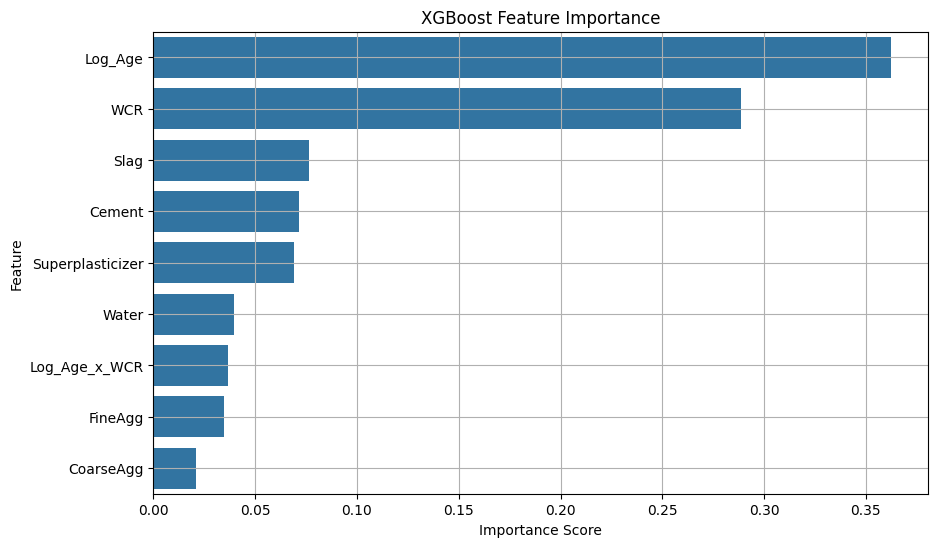

In [67]:
xgb_model = pipeline.named_steps["model"]
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance,
    x="Importance",
    y="Feature"
)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid()
plt.show()

Feature importance analysis confirms that curing age, water–cement ratio dominate strength prediction, aligning with established concrete hydration theory.

**Finding the Best Mix Design**

In [70]:
data = pd.read_csv('Processed_Material_Strength_Dataset.csv')

# Engineer necessary features
data['WCR'] = data['Water'] / data['Cement']
data['Age_x_WCR'] = data['Age'] * data['WCR']
data['Log_Age'] = np.log1p(data['Age'])
data['Log_Age_x_WCR'] = data['Log_Age'] * data['WCR']

# Select features used in the model
X_columns = ['Cement', 'Slag', 'Water', 'Superplasticizer',
             'CoarseAgg', 'FineAgg', 'WCR', 'Log_Age', 'Log_Age_x_WCR']

X = data[X_columns]

# Predict using your trained pipeline
y_log_pred = pipeline.predict(X)
y_pred = np.expm1(y_log_pred)

data['Predicted_Strength'] = y_pred

# Find the row with maximum predicted strength
best_mix = data.loc[data['Predicted_Strength'].idxmax()]

best_mix = pd.Series({
    'Cement (kg/m³)': best_mix['Cement'],
    'Slag (kg/m³)': best_mix['Slag'],
    'FlyAsh (kg/m³)': best_mix['FlyAsh'],
    'Water (kg/m³)': best_mix['Water'],
    'Superplasticizer (kg/m³)': best_mix['Superplasticizer'],
    'Coarse Aggregate (kg/m³)': best_mix['CoarseAgg'],
    'Fine Aggregate (kg/m³)': best_mix['FineAgg'],
    'Curing Age (days)': best_mix['Age'],
    'Water-to-Cement Ratio': best_mix['WCR'],
    'Age x WCR': best_mix['Age_x_WCR'],
    'Predicted Strength (MPa)': best_mix['Predicted_Strength']
})

print("Best Mix Design (Predicted Strength):")
print(best_mix)

Best Mix Design (Predicted Strength):
Cement (kg/m³)              389.900000
Slag (kg/m³)                189.000000
FlyAsh (kg/m³)                0.000000
Water (kg/m³)               145.900000
Superplasticizer (kg/m³)     22.000000
Coarse Aggregate (kg/m³)    944.700000
Fine Aggregate (kg/m³)      755.800000
Curing Age (days)            91.000000
Water-to-Cement Ratio         0.374199
Age x WCR                    34.052065
Predicted Strength (MPa)     78.699738
dtype: float64


The model predicts the highest compressive strength (~79 MPa) for a mix with high cement (390 kg/m³), moderate water (146 kg/m³), maximum slag (189 kg/m³), and high superplasticizer (22 kg/m³), at 91 days curing. This confirms that careful balance of WCR and admixtures maximizes strength.

**Saving Model in System**

In [ ]:
import joblib

# Save the trained pipeline
joblib.dump(pipeline, "xgboost_material_strength_model.pkl")

from google.colab import files

files.download("xgboost_material_strength_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Conclusion

1. The final model achieved high predictive accuracy with strong cross-validation consistency, indicating good generalization.

2. Training on a log-transformed target helped stabilize variance and reduced heteroscedastic effects commonly observed in concrete strength data.

3. Residual analysis showed minimal systematic bias across all strength ranges, with higher variability at high strengths consistent with physical behavior.

4. Feature importance results confirmed that curing age, water–cement ratio, and their interaction are the dominant factors influencing strength.

Overall, the model is robust, physically meaningful, and suitable for real-world material strength prediction